# Import libraries

In [1]:
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter
from collections import defaultdict



In [2]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [42]:
INPUT_FOLDER = "input_imgs"
OUTPUT_FOLDER = "lowpoly"

os.makedirs(INPUT_FOLDER, exist_ok=True)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [4]:
im_arr = None
points = None


In [5]:
def read_process_input(filename):
	global im_arr
	im = Image.open(os.path.join(INPUT_FOLDER, filename))
	im_arr = np.array(im)
	# plt.imshow(im)
	perceptual_weight = np.array([0.2126, 0.7152, 0.0722])
	grayscale = (im * perceptual_weight).sum(axis=-1)
	plt.figure()
	plt.imshow(grayscale);

	x = gaussian_filter(grayscale, 2, mode="reflect")
	x2 = gaussian_filter(grayscale, 30, mode="reflect")

	# Take the difference, deweight negatives, normalise
	diff = (x - x2)
	diff[diff < 0] *= 0.1
	diff = np.sqrt(np.abs(diff) / diff.max())

	# plt.imshow(diff)
	return diff, im_arr

	

In [6]:
def sample_im(ref, n=1000000):
	np.random.seed(0)
	h,w = ref.shape
	xs = np.random.randint(0, w, size=n)
	ys = np.random.randint(0, h, size=n)
	value = ref[ys,xs]
	accept = np.random.random(size=n) < value
	points = np.array([xs[accept], ys[accept]])
	return points.T, value[accept]

In [7]:
def get_samples(diff):
	samples, v = sample_im(diff)
	plt.figure()
	plt.scatter(samples[:,0], -samples[:,1], c=v, s=0.2, edgecolors="none", cmap="viridis")

	return samples

In [8]:
def get_colour_of_tri(tri, img):
	colours = defaultdict(lambda: [])
	# w, h = img.size
	h, w, _ = img.shape
	# img_arr = np.array(img)
	for i in range(0, w):
		for j in range(0,h):
			index = tri.find_simplex((i,j))
			colours[int(index)].append(img[j,i,:])
	
	for index, array in colours.items():
		colours[int(index)] = np.array(array).mean(axis=0)
	return colours

In [59]:
def load_plot_inp(filename):
	print("Normalized and highlighted:")
	diff, im_arr = read_process_input(filename)

	print("Scatter plot")
	samples = get_samples(diff)

	h,w,_ = im_arr.shape

	corners = np.array([(0,0), (0, h-1), (w-1, 0), (w-1, h-1)])
	points = np.concatenate((corners, samples))

	return points, im_arr, filename
	
	
	

In [25]:
def generate_art(N, im_arr, points):
	n = 5 + N + 2 * int(N**2)
	print(n)

	tri = Delaunay(points[:n, :])
	colours = get_colour_of_tri(tri, im_arr)

	h,w, _ = im_arr.shape
	im_out = Image.new("RGB", (w,h))
	# print(im_out.size)
	im_draw = ImageDraw.Draw(im_out)
	for key,c in colours.items():
		t = tri.points[tri.simplices[key]]
		# t[:, 0], t[:, 1] = t[:, 1], t[:, 0].copy()
		# print(t, len(t))
		color = tuple(c.astype(np.uint8))
		im_draw.polygon(t.flatten().tolist(),fill=color, outline=color)

	# im_out = im_out.resize(im.size)
	plt.imshow(im_out)
	# im_out.save(f'lowpoly/out_{n}.png')
	return(im_out)

In [62]:
w = interactive(load_plot_inp, filename=os.listdir(INPUT_FOLDER))

In [63]:
display(w)

interactive(children=(Dropdown(description='filename', options=('148709192_389763002821550_8674950514758180380…

In [66]:
points, im_arr, inp_name = w.result

In [54]:
w2 = interactive(generate_art, N=widgets.IntSlider(min=1, max=100, step=1, value=45), im_arr=fixed(im_arr), points=fixed(points))

In [55]:
display(w2)

interactive(children=(IntSlider(value=45, description='N', min=1), Output()), _dom_classes=('widget-interact',…

In [56]:
out = w2.result

# out.show()

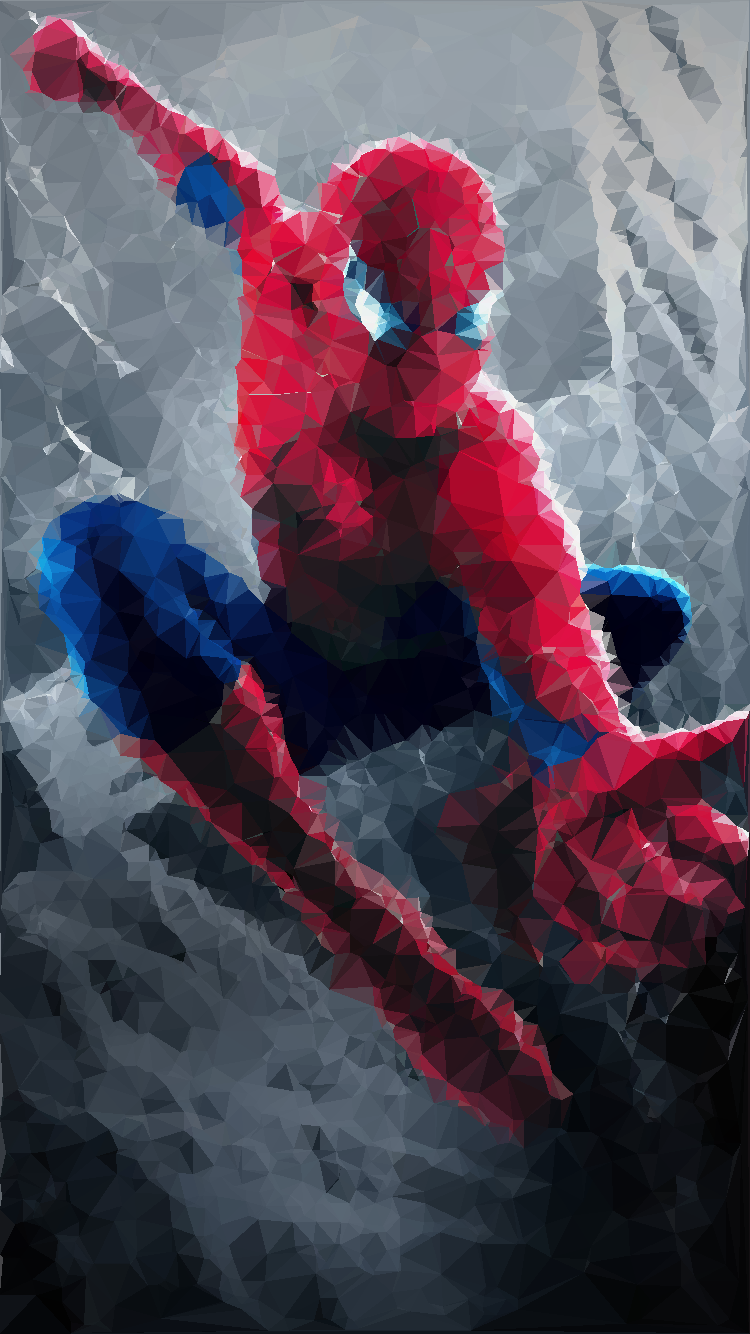

In [57]:
out

In [58]:
out.save(f"{OUTPUT_FOLDER}/{inp_name}")